## Import Libraries

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
import torch
import pickle
from glob import glob
from WeightedLDA import WeightedLDA as WL
from shapeGMMTorch import ShapeGMM
from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts

if torch.cuda.device_count()>0:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

output_folder = "outputs/clustering_biased"
os.makedirs(output_folder, exist_ok=True)
# if regenerate is false, clustering steps will be skipped if output files already exist
regenerate=False

In [2]:
from MDAnalysis.lib.distances import calc_dihedrals

def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

## perform cluster scan using biased simulation data 

### load trajectory from a particular simulation

In [8]:
metad_path = "../generate_data/metad_lda"
data_path = os.path.join(metad_path,"bias_l1_h0.5_bf8_s0.4")
input_path = "../generate_data/inputs/"
atoms_selection = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

top_file=  os.path.join(input_path,"alaA.pdb")
traj_files = glob(os.path.join(data_path,"alaA_*.trr"))

univ = md.Universe(top_file, traj_files)
sel_atoms = univ.select_atoms(atoms_selection)

print("selected atom indices:", ",".join(np.array(sel_atoms.indices+1, dtype=str)))
print("Number of atoms in trajectory:", univ.atoms.n_atoms)
print("Number of frames in trajectory:", univ.trajectory.n_frames)
print("Number of atoms being analyzed:", sel_atoms.n_atoms)
print("Number of frames being analyzed:", univ.trajectory.n_frames)

trajData = np.empty((univ.trajectory.n_frames, sel_atoms.n_atoms, 3), dtype=float)
count = 0

for ts in univ.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atom indices: 5,7,9,15,17
Number of atoms in trajectory: 22
Number of frames in trajectory: 20001
Number of atoms being analyzed: 5
Number of frames being analyzed: 20001


### load COLVAR data as well

In [15]:
ld1, phi, psi, meta_rbias = np.loadtxt(glob(os.path.join(data_path,"alaA*.cv.dat"))[0], usecols=(1,2,3,5), unpack=True)  
kt = 0.596161

wgts = np.exp(meta_rbias/kt)
wgts /= np.sum(wgts)
print(wgts.shape)

(20001,)


$\textbf{cluster scan}$

In [16]:
cluster_array = np.arange(2,7).astype(int)
print("Scanning cluster sizes K:",cluster_array)

Scanning cluster sizes K: [2 3 4 5 6]


In [28]:
%%time
train_file = os.path.join(output_folder,'train_bias.dat')
cv_file = os.path.join(output_folder,'cv_bias.dat')
if os.path.exists(cv_file) and regenerate is False:
    train = np.loadtxt(train_file)
    cv = np.loadtxt(cv_file)
else:
    train, cv = cross_validate_component_scan(trajData, frame_weights=wgts, train_fraction=0.90, covar_type="kronecker", 
                                              component_array = cluster_array, n_training_sets=3, n_attempts = 8, 
                                              init_component_method = "kmeans++", dtype=torch.float64, device=device)
    
    # save
    np.savetxt(train_file, train)
    np.savetxt(cv_file, cv)

CPU times: user 1.74 ms, sys: 992 μs, total: 2.73 ms
Wall time: 2.19 ms


              3               3               5             32.4501          41.003
              3               3               6             31.6032         101.016
              3               3               7             32.4549          47.993
              3               3               8             32.4561          19.545
              3               4               1             33.2068          59.426
              3               4               2             33.2120         119.684
              3               4               3             32.6923          63.218
              3               4               4             32.8746          82.901
              3               4               5             33.0745         118.722
              3               4               6             32.8372          75.228
              3               4               7             33.2854          46.200
              3               4               8             33.0914         

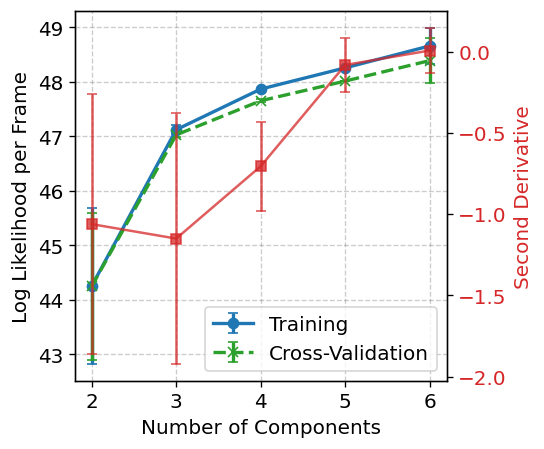

In [29]:
from shapeGMMTorch.utils import plot_log_likelihood_with_dd

# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plot_log_likelihood_with_dd(ax, cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

$\textbf{perform ShapeGMM fit with 3 clusters}$

In [30]:
%%time

wsgmm3_file = os.path.join(output_folder,'wsgmm3_bias.pickle')
if os.path.exists(wsgmm3_file) and regenerate is False:
    with open(wsgmm3_file, 'rb') as fo:
        pickle.load(fo)
else:
    wsgmm3_bias = sgmm_fit_with_attempts(trajData, 3, 15, init_component_method='kmeans++', frame_weights=wgts, device=device, dtype=torch.float64)
    
    with open(wsgmm3_file, 'wb') as fo:
        pickle.dump(wsgmm3_bias, fo)

CPU times: user 714 μs, sys: 954 μs, total: 1.67 ms
Wall time: 1.17 ms


In [31]:
# predict
comp_ids_bias_3state = wsgmm3_bias.predict(trajData)
print(comp_ids_bias_3state.shape)

(20001,)


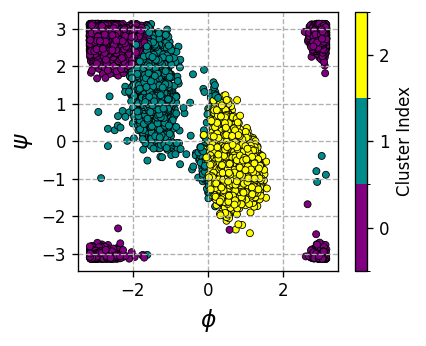

In [33]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'yellow']
cluster_boundaries = [0, 1, 2, 3]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=comp_ids_bias_3state, marker='.', cmap=cmap, norm=norm, edgecolor='k', s=70, linewidths=0.5)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 3, 1))
cbar.set_ticklabels(np.arange(3))
cbar.set_label('Cluster Index')

$\textbf{perform ShapeGMM fit with 4 clusters}$

In [37]:
%%time

wsgmm4_file = os.path.join(output_folder,'wsgmm4_bias.pickle')
if os.path.exists(wsgmm4_file) and regenerate is False:
    with open(wsgmm4_file, 'rb') as fo:
        wsgmm4_bias = pickle.load(fo)
else:
    wsgmm4_bias = sgmm_fit_with_attempts(short_traj, 4, 15, init_component_method='kmeans++', frame_weights=wgts, device=device, dtype=torch.float64)
    
    with open(wsgmm4_file, 'wb') as fo:
        pickle.dump(wsgmm4_bias, fo)


CPU times: user 2.43 ms, sys: 42 μs, total: 2.47 ms
Wall time: 11.3 ms


In [38]:
# predict
comp_ids_bias_4state = wsgmm4_bias.predict(trajData)
print(comp_ids_bias_4state.shape)

(20001,)


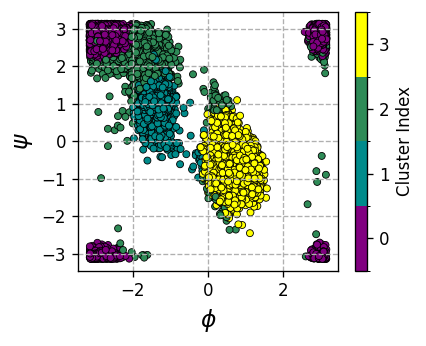

In [39]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'seagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.xlabel("$\phi$", fontsize=14)
plt.ylabel("$\psi$", fontsize=14)
plt.grid(axis='both', which='major', linestyle='--',)
im = plt.scatter(phi, psi, c=comp_ids_bias_4state, marker='.', cmap=cmap, norm=norm, edgecolor='k', s=70, linewidths=0.5)
cbar = plt.colorbar(im, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')

### Compute bhattacharya distances of new cluster centers wrt initial clusters

In [40]:
from shapeGMMTorch.utils import similarity

In [41]:
with open("outputs/clustering/wsgmm3.pickle", "rb") as fo:
    wsgmm_ref = pickle.load(fo)

print(wsgmm_ref.weights_)
print(wsgmm_ref.means_.shape)

[0.5        0.26400697 0.23599303]
(3, 5, 3)


In [42]:
wsgmm_list = [wsgmm3_bias, wsgmm4_bias]

In [43]:
dist_data = []

# loop over objects [3,4]
for i in range(2):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_components):
        
        # wrt 0
        dij_0 = similarity.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 1
        dij_1 = similarity.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 1)
        
        vals.append([dij_0, dij_1])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y


In [44]:
print(dist_data)

[array([[3.95767284, 2.46887171],
       [3.9803314 , 1.51551128],
       [0.93153132, 3.84493545]]), array([[4.32064193, 2.75585487],
       [4.18181881, 1.55451161],
       [3.49455829, 1.66260707],
       [0.98480921, 3.84797099]])]


$\textbf{Plot Bhattacharyya distances for 3 clusters}$

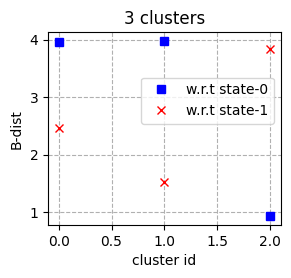

In [45]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
wsgmm = wsgmm_list[0]
for i in range(wsgmm.n_components):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t state-0" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t state-1" if i == 0 else "")
plt.legend(loc='best', bbox_to_anchor=[1.0,0.8])


$\textbf{Plot Bhattacharyya distances for 4 clusters}$

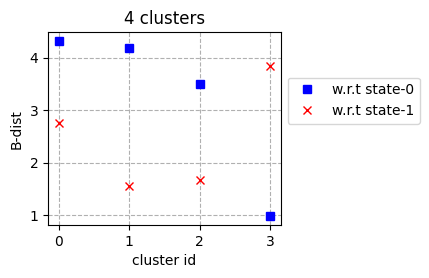

In [46]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
wsgmm = wsgmm_list[1]
for i in range(wsgmm.n_components):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t state-0" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t state-1" if i == 0 else "")
plt.legend(loc='best', bbox_to_anchor=[1.0,0.8])
